In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym.spaces
import time
import copy
import threading
import time
import collections

In [ ]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ['human'] }
    
    def __init__(self, normalize=False, size=4):
        self.observation_space = gym.spaces.Box(0, size, (size,))
        self.action_space = gym.spaces.Discrete(4)
        self.max_timesteps = size*2 + 1
        self.normalize = normalize
        self.size = size

        # Generate State Transition Table
        self.transition_matrix = []
        for x in range(size + 1):
            state_x = []
            for y in range(size + 1):
                state_y = []
                for a in range(4):
                    one_hot = np.zeros(4)
                    one_hot[a] = 1
                    state_y.append(one_hot)
                state_x.append(state_y)
            self.transition_matrix.append(state_x)
        
    def transition_func(self, x, y, action, return_probs=False):
        probs = self.transition_matrix[x][y][action]
        if return_probs:
            return probs
        else:
            return np.random.choice(len(probs), p=probs)

    def _get_distance(self, x, y):
        return abs(x[0] - y[0]) + abs(x[1] - y[1])
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size, self.size]
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.prev_distance = self._get_distance(self.agent_pos, self.goal_pos)
        return np.array(self.agent_pos)/1.
    
    def step(self, action):
        action_taken = self.transition_func(self.agent_pos[0], self.agent_pos[1], action)
        self.state = np.random.choice(self.observation_space.shape[0])
        if action_taken == 0:
            self.agent_pos[0] += 1
        if action_taken == 1:
            self.agent_pos[0] -= 1
        if action_taken == 2:
            self.agent_pos[1] += 1
        if action_taken == 3:
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.size)
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        
        current_distance = self._get_distance(self.agent_pos, self.goal_pos)
        if current_distance < self.prev_distance:
            reward = 1
        elif current_distance > self.prev_distance:
            reward = -1
        else:
            reward = -1
        self.prev_distance = current_distance
        
        self.timestep += 1
        if self.timestep >= self.max_timesteps or current_distance == 0:
            done = True
        else:
            done = False
        info = {}
        
        obs = self.agent_pos
        if self.normalize:
            obs = obs/self.size
        return obs, reward, done, info
        
    def render(self, mode='human'):
        plt.imshow(self.state)

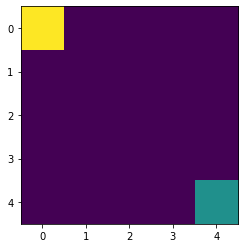

In [ ]:
env = GridEnvironment()
obs = env.reset()
env.render()

In [ ]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        return np.random.choice(self.action_space.n)
        
    def step(self, observation, verbose=False):
        return self.policy(observation)

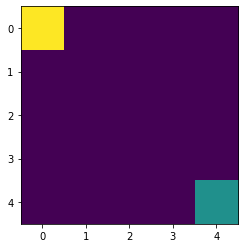

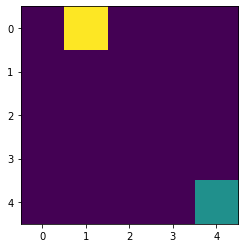

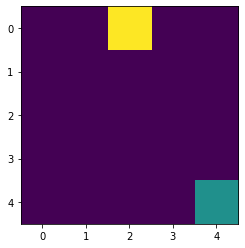

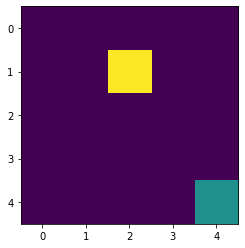

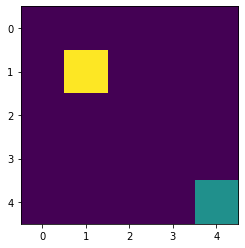

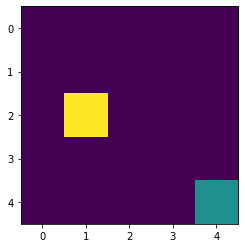

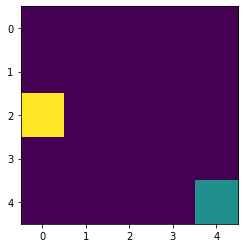

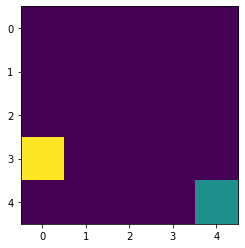

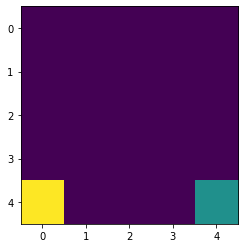

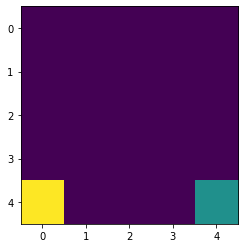

In [ ]:
env = GridEnvironment(normalize=True)
agent = RandomAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

In [ ]:
class HeuristicAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        # 0 - down
        # 1 - up
        # 2 - right
        # 3 - left
        if (observation[0] < 1.):
            return 0
        if (observation[1] < 1.):
            return 2
        return 0
        
    def step(self, observation, verbose=False):
        if verbose:
            print(observation)
        return self.policy(observation)

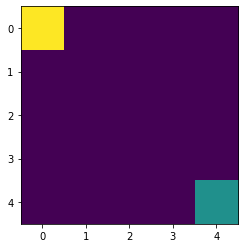

[0. 0.]


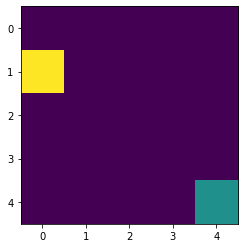

[0.25 0.  ]


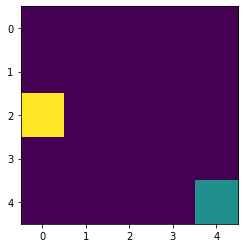

[0.5 0. ]


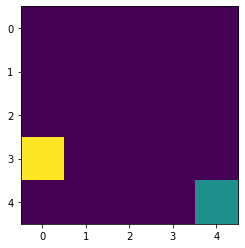

[0.75 0.  ]


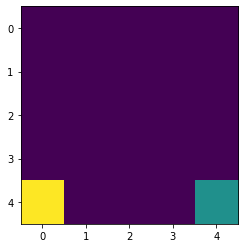

[1. 0.]


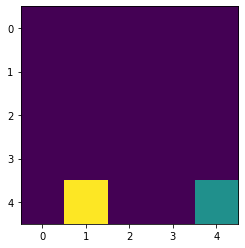

[1.   0.25]


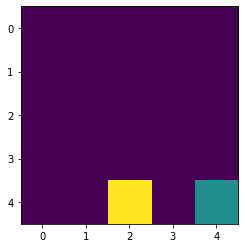

[1.  0.5]


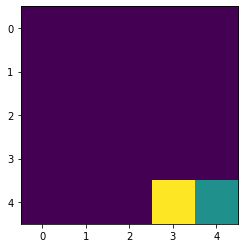

[1.   0.75]


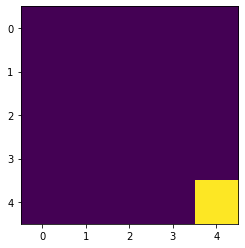

In [ ]:
env = GridEnvironment(normalize=True)
agent = HeuristicAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

In [ ]:
class QLearningAgent:
    def __init__(self, env, epsilon=1.0, lr=0.1, gamma=0.9):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        q_table_dim = env.observation_space.shape[0] + 1
        self.q_table = np.zeros((q_table_dim, q_table_dim, env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

    def policy(self, observation):
      # Code for policy (Task 1) (30 points)
      if np.random.random() < self.epsilon:
        action = np.random.choice(self.action_space.n)
      else:
        observation = observation.astype(int)
        action = np.argmax(self.q_table[observation[0]][observation[1]])
      return(action)
        
    def step(self, observation):
      return self.policy(observation)
        
    def update(self, state, action, reward, next_state):
        state = state.astype(int)
        next_state = next_state.astype(int)
        # Code for updating Q Table (Task 2) (20 points)
        self.q_table[state[0]][state[1]][action] = (1- self.lr)*self.q_table[state[0]][state[1]][action] + self.lr*(reward + self.gamma*(np.max(self.q_table[next_state[0]][next_state[1]][action])))
        return self.q_table
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

In [ ]:
env = GridEnvironment() # note: we do not normalize
agent = QLearningAgent(env)
episodes = 1000 # number of games we want the agent to play
delta_epsilon = agent.epsilon/episodes
decay_rate = 0.99

total_rewards = []
epsilons = []

# Training Process (Task 3) (20 points)
for i in range(episodes):
  obs = env.reset()
  done = False
  epsilons.append(agent.epsilon)
  while (done == False):
    action = agent.step(obs)
    #current_state = obs
    new_state, reward, done, info = env.step(action)
    total_rewards.append(reward)
    agent.update(obs, action, reward, new_state)
    obs = new_state.copy()
  agent.set_epsilon(max(agent.epsilon*decay_rate, .1))   



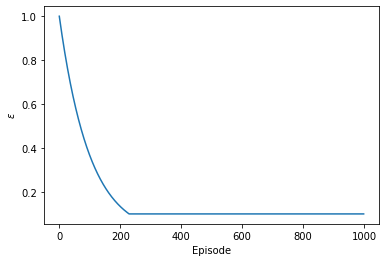

In [ ]:
plt.xlabel('Episode')
plt.ylabel('$\epsilon$')
plt.plot(epsilons)

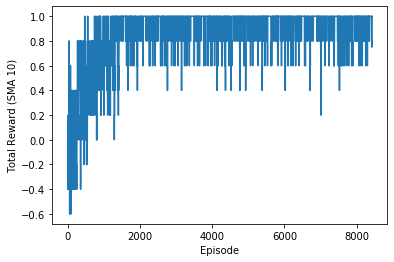

In [ ]:
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])

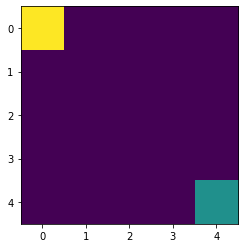

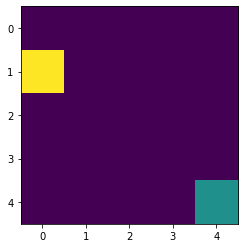

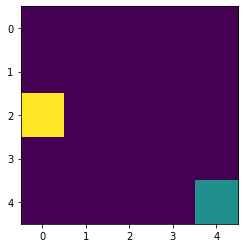

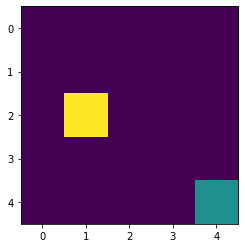

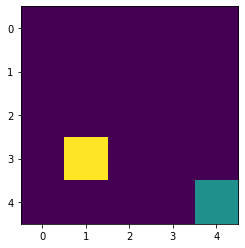

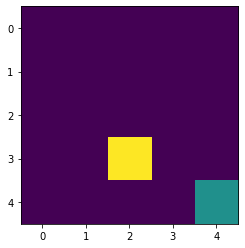

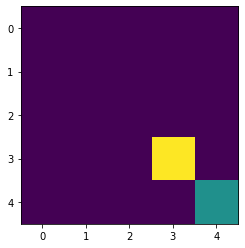

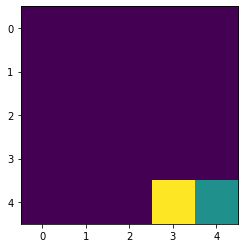

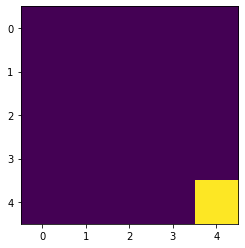

In [ ]:
env = GridEnvironment()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

In [ ]:
agent.q_table

array([[[ 3.28406185, -4.52843358,  1.33457273, -4.12963218],
        [ 2.77361404, -0.77255306,  0.49951   , -1.23164736],
        [ 1.01742328, -0.29701   ,  0.1       , -0.32104842],
        [ 0.19      , -0.1       ,  0.1       ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 2.53784651, -4.81102876,  2.17791573, -4.69094457],
        [ 2.31025177, -1.31886212,  1.3392059 , -1.68868358],
        [ 1.30276671, -0.62952666,  0.558559  , -0.86241479],
        [ 1.00623331, -0.2071    ,  0.1       , -0.29030128],
        [ 0.19      ,  0.        , -0.1       , -0.11126839]],

       [[ 1.70871834, -4.91460124,  2.13821819, -3.17445405],
        [ 1.45509249, -1.28054974,  1.27491666, -2.17887298],
        [ 0.4177    , -0.66027353,  1.29100824, -0.61575919],
        [ 1.19576637, -0.53845123,  0.3439    , -0.40257124],
        [ 0.83709372, -0.19      ,  0.        ,  0.        ]],

       [[ 0.78746483, -4.16139164,  2.9037719 , -2.60299627],
  

4


2
